## Vapor surrounding two-dimensional growing and ablating hexagonal crystals

### Part 1. Establishing geometrical properties hexagons and their equivalent circles
We'll need to know the relationship between the distnces, $r_{hex}$, $r'_{hex}$, $r_{eff}$, and $L$, shown in Fig. 1.

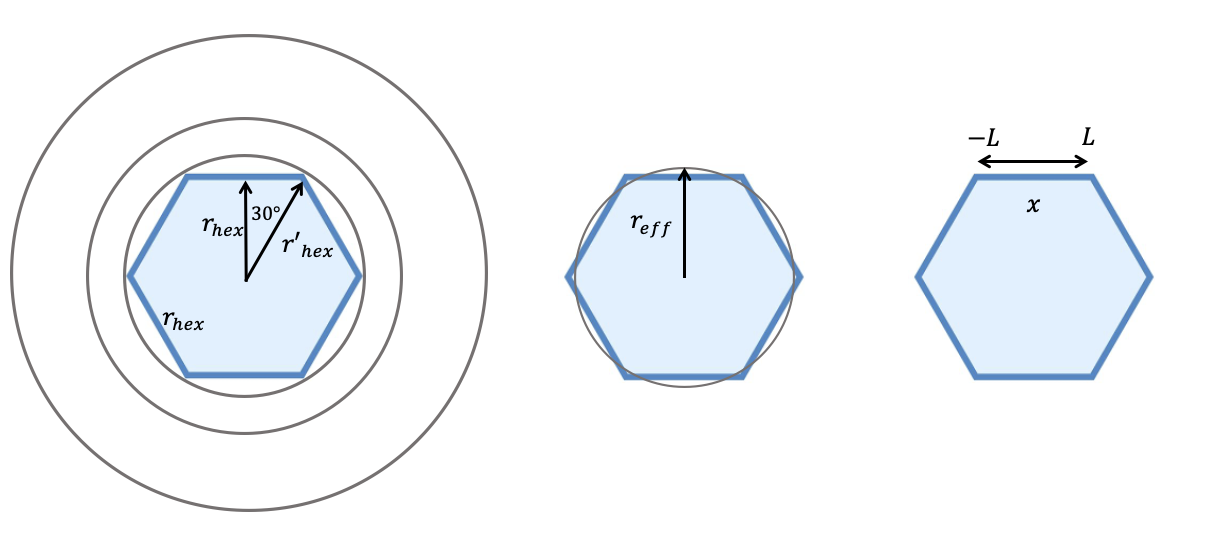\
**Figure 1**. Geometrical properties of a hexagonal crystal in a spherically-symmetric vapor field.

For example, $r_{eff}$ is designated in such a way that the circumference of the circular crystal equals the perimeter length of the hexagon,

$$
r_{eff} = {6 r_{hex} \over 2 \pi} \ \ \ \ (1) 
$$

It is a property of hexagons that $L=r_{hex}/2$. $r'_{hex}$ can be obtained from $r_{hex}$ from trigonometry.

### Part 2. Computing vapor pressures around a growing/ablating two-dimensional hexagonal crystal
Equations 11-13 of VH_2Dsquare.ipynb show how to find parameters $P_1$ and $r_0$ needed by the analytical solution for our "CND system" ("CND stands for a circular crystal of radius $r$, with Neumann conditions at $r$, situated within a circular Dirichlet-condition far-field boundary at $r_f$). These parameters can be made to reflect either growth or ablation at the crystal surface. Once we have them, we can use 

$$
P_{vap} = P_1 \times (1-{r_0 \over r}) \ \ \ \ (2)
$$ 

(which is Eq. 4 of VH_2Dsquare.ipynb) to calculate $P_{vap}$ at any distance from the center. We can also compute supersaturations over the length of a facet:

$$
\sigma_I(x) = {P_{vap}(r(x)) \over P_I^*}-1 \ \ \ \ (3)
$$

where (see Fig. 1)

1. "x" measures the distance on a path from facet center (where $x=0$ and $r=r_{hex}$) out to facet corners (where $x=\pm L$ and $r=r'_{hex}$); 
1. "r" is a function of "x" as one proceeds along that path; and
1. $P_I^*$ is the equilibrium vapor pressure of water at a given temperature, obtained from the Clausius-Clapeyron equation.


### Part 3. Constructing and evaluating the parabolic appoximation to $\sigma_I(x)$
Once we have the above quantities, we'll be in a position to construct a parabolic approximation to the supersaturation along a facet. For reference, we'll call this the the CNDP approximation. It is given by

$$
\sigma_I(x) \approx \sigma_I(corner) \times \bigl (c_r ({x \over L})^2 +1 -c_r \bigr )  \ \ \ \ (4)
$$

where $\sigma_I(corner)$ is the supersaturation at facet corners, which we get from Eq. 3 by specifying $r=r'_{hex}$, and

$$
c_r \equiv 1 - {\sigma_I(middle) \over \sigma_I(corner)} \ \ \ \ (5)
$$

(here we define $\sigma_I(middle)$ analogously to $\sigma_I(corner)$, i.e., the supersaturation at facet middle, which we get from Eq. 3 by specifying $r=r_{hex}$).

We can evaluate how good CNDP is by two kinds of comparison. One is to graph it alongside the CND result, across a facet (i.e., from $x=\pm L$). A second method is to solve the problem numerically. That is, we numerically solve the diffusion problem laid out in Fig. 1, in two dimensions, and graph the resulting supersaturation over the surface of a facet, alongside the CND and CNDP results. This second method sounds like a lot of work, but fortunately most has already been done: we can modify existing code that numerically solves for the vapor pressure around a growing/ablating square crystal.

### Part 4. Vapor pressure around a 3D crystal
The logical next step is to extend this analysis to three dimensions, as shown in Fig. 2. This would entail:
1. Finding an analytical solution to the diffusion of water vapor around a spherical crystal of radius $r$, with Neumann conditions at $r$, situated within a spherical Dirichlet-condition far-field boundary. I think it'll look like $P_{vap} = P_1 \times (1-{r_0^2 \over r^2})$, where $P_1$ and $r_0$ are new parameters, but we'll have to verify that of course (we do that by applying the spherical-polar Laplacian to our proposed $P_{vap}$, and seeing if we get zero). We could call this the SND system (for "spherical crystal with Neumann conditions at $r$, situated within a circular Dirichlet-condition far-field boundary"); 
1. Using the SND approximation to find vapor pressures and supersaturations across the surface of each facet shown in Fig. 2. There will actually be only two of these that are unique: the basal facet and the prismatic facet). Because these are 2D facets, each will be a function of two coordinates, e.g., $\sigma_{I,basal}(x,y)$ and $\sigma_{I,prismatic}(x,y)$; and
1. Constructing SNDP, a parabolic approximation to SND. This will actually be a bi-parabolic equation, something like $\sigma_I(x,y) \approx \sigma_I(x) + \sigma_I(y)$, with two curvature parameters $c_{r,x}$ and $c_{r,y}$, etc. We can imagine evaluating this approximation in the same way we evaluated CNDP, namely, by plotting them alongside one another. A further test would be to compare to numerical solutions to the 3D diffusion problem shown in Fig. 2.

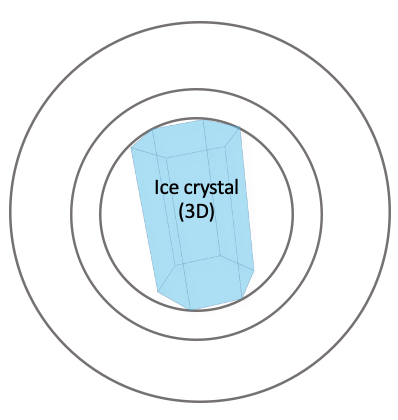
**Figure 2**. Extension to a hexagonal crystal in three dimensions.

In [20]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from matplotlib import rcParams

# QLC-specific code
import QLCstuff as QLC; reload(QLC)

<module 'QLCstuff' from '/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py'>

In [21]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

### Defining system and run parameters

In [22]:
# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

# Temperature
Temperature = AssignQuantity(250,'kelvin')
print('Temperature =',Temperature)

# Ambient pressure
Pressure = AssignQuantity(30,'pascal')
print('Pressure =', Pressure)

# Diffusion through air
Dvap = QLC.getDofTP(Temperature,Pressure,AssignQuantity)
print('Dvap =',Dvap)

# Size of the box
L = AssignQuantity(30,'micrometer')
print('L =', L)

# The far-field distance
r_f = AssignQuantity(2000,'micrometer')

# The far-field supersaturation
sigmaI_far_field = 0.25
print('sigmaI, far field =',sigmaI_far_field)

# Growth rate of the crystal
g_ice = AssignQuantity(8.6,'micrometer/second')
print('g_ice = ',g_ice)

# The Neumann parameter "g'"
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')
g_vap = rho_ice*g_ice*R*Temperature/Mvap; #print(gprime)
g_vap.ito('pascal * micrometer / second'); #print(gprime)
gprime = g_vap # Renaming this because it's called gprime in the code below

# Equilibrium vapor stuff
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vap_eq = P3*np.exp(-Delta_H_sub/R*(1/Temperature-1/T3))
print('P_vap_eq =', P_vap_eq)

# The far-field pressure
P_f = P_vap_eq * (sigmaI_far_field+1)
print('P_f =', P_f)

Temperature = 250 kelvin
Pressure = 30 pascal
Dvap = 62773.26202925995 micrometer ** 2 / microsecond
L = 30 micrometer
sigmaI, far field = 0.25
g_ice =  8.6 micrometer / second
P_vap_eq = 80.5128693847561 pascal
P_f = 100.64108673094512 pascal


chi = 12263.200377242098 dimensionless
r0 = 0.16307626575567646 micrometer


<IPython.core.display.Javascript object>


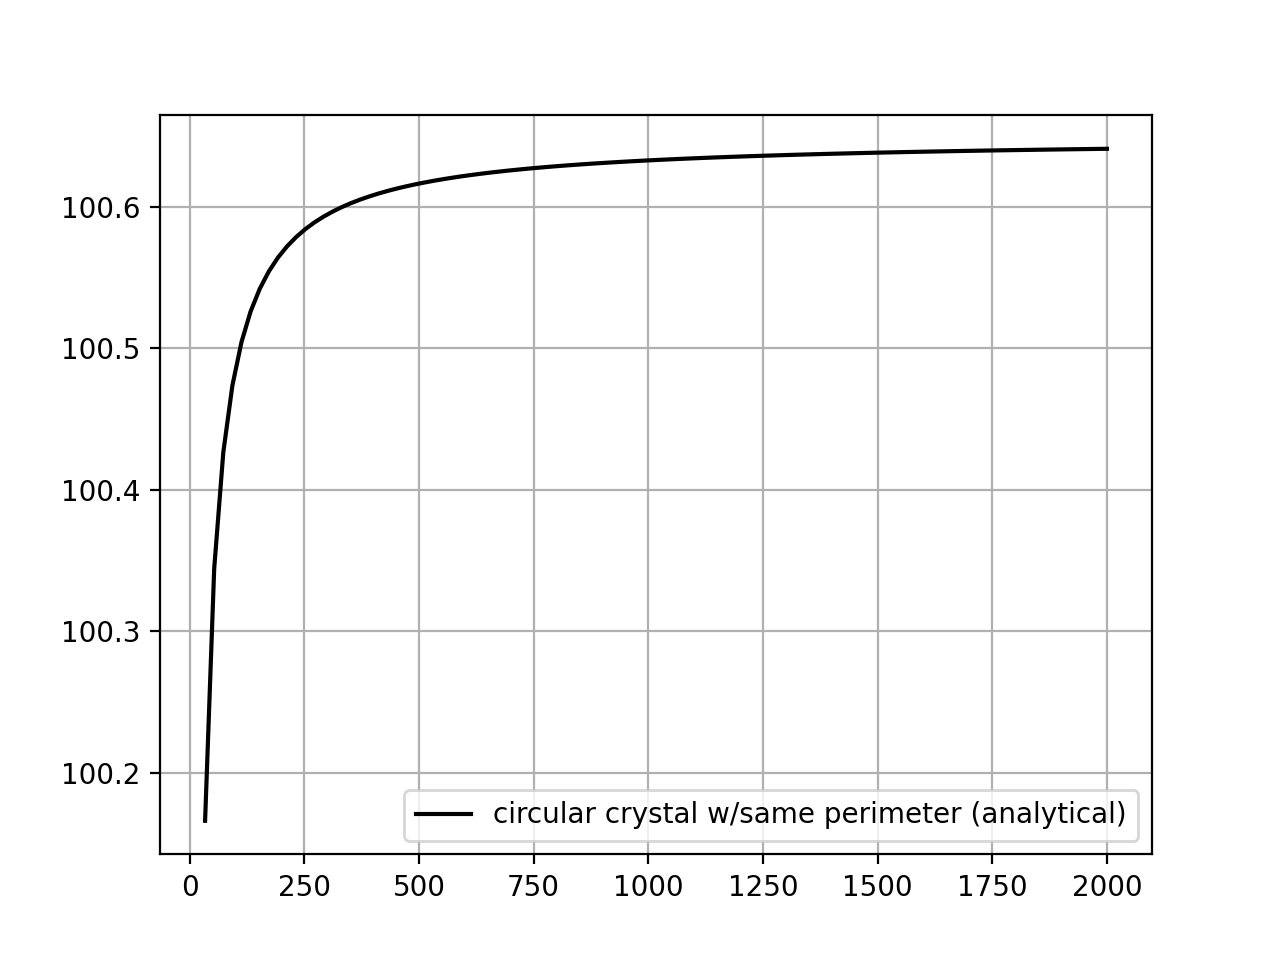

In [27]:
# Here's calculating parameters for the analytical result
chi = Dvap*P_f*r_f/(gprime*L_eff**2); chi.ito('dimensionless'); print('chi =', chi)
r_0 = r_f/(1+chi); print('r0 =', r_0)
P1 = P_f/(1-r_0/r_f)

# Here's the range of r-values to use for the analytical result
r_analytical = np.linspace(L_eff,r_f,100)
P_analytical = P1*(1-r_0/r_analytical)
# r_analytical_extended = ...
# P_analytical_extended = ...

# Visualize as a function of distance from the side or corner of the crystal
plt.figure()
plt.plot(r_analytical,P_analytical,'k-',label='circular crystal w/same perimeter (analytical)')
# plt.plot(r_analytical_extended,P_analytical_extended,'k--',label='circular crystal w/same perimeter (extended)')
plt.legend()
# plt.xlim(L.magnitude,x_entire[-1].magnitude)
plt.grid(True)

# Calculating c_r from all this
# L_corner = Lx_actual*2**.5
# P_vap_corner = P1*(1-r_0/L_corner)
# print('P_vap_corner =', P_vap_corner)
# sigmaI_corner = P_vap_corner/P_vap_eq - 1
# print('analytical sigmaI_corner =', sigmaI_corner)
# P_vap_middle = P1*(1-r_0/Lx_actual)
# print('P_vap_middle =', P_vap_middle)
# sigmaI_middle = P_vap_middle/P_vap_eq - 1
# print('analytical sigmaI_middle =', sigmaI_middle)
# c_r_analytical = 1 - sigmaI_middle/sigmaI_corner
# c_r_analytical_percent = c_r_analytical*100
# print('analytical c_r(%) =', c_r_analytical_percent)